In [2]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/gitrepos/gsm-paper`


In [3]:
using CairoMakie
using MLJ, GenerativeTopographicMapping
using DataFrames, CSV
using Distributions, Statistics
using LinearAlgebra
using Random, StableRNGs

In [6]:
include("./utils/hysu.jl");

In [8]:
# set the default rng for reproducibility
rng = StableRNG(42);

In [9]:
# set up plot defaults
include("./utils/makie-defaults.jl")

set_theme!(mints_theme);

update_theme!(
    figure_padding=30,
    Axis=(
        xticklabelsize=20,
        yticklabelsize=20,
        xlabelsize=22,
        ylabelsize=22,
        titlesize=25,
    ),
    Colorbar=(
        ticklabelsize=20,
        labelsize=22
    )
)

Set up datapaths and read in the data

In [11]:
datapath_all = "./data/hysu/all.csv"
datapath_large = "./data/hysu/large.csv"
datapath_small = "./data/hysu/small.csv"
@assert ispath(datapath_all)
@assert ispath(datapath_large)
@assert ispath(datapath_small)

figpath = "./figures/hysu"
if !isdir(figpath)
    mkdir(figpath)
    mkdir(joinpath(figpath, "all"))
    mkdir(joinpath(figpath, "large"))
    mkdir(joinpath(figpath, "small"))
end

In [14]:
df_ref = CSV.read("./data/hysu/reference-spectra.csv", DataFrame)
df_svc = CSV.read("./data/hysu/svc-spectra.csv", DataFrame)



df_all = CSV.read(datapath_all, DataFrame);
df_large = CSV.read(datapath_large, DataFrame);
df_small = CSV.read(datapath_small, DataFrame);

X_all = Array(df_all);
X_large = Array(df_large);
X_small = Array(df_small);

println("Rows in All: ", nrow(df_all))
println("Rows in Large: ", nrow(df_large))
println("Rows in Small: ", nrow(df_small))

Rows in All: 884
Rows in Large: 208
Rows in Small: 144


# Visualize the Datasets

All targets dataset

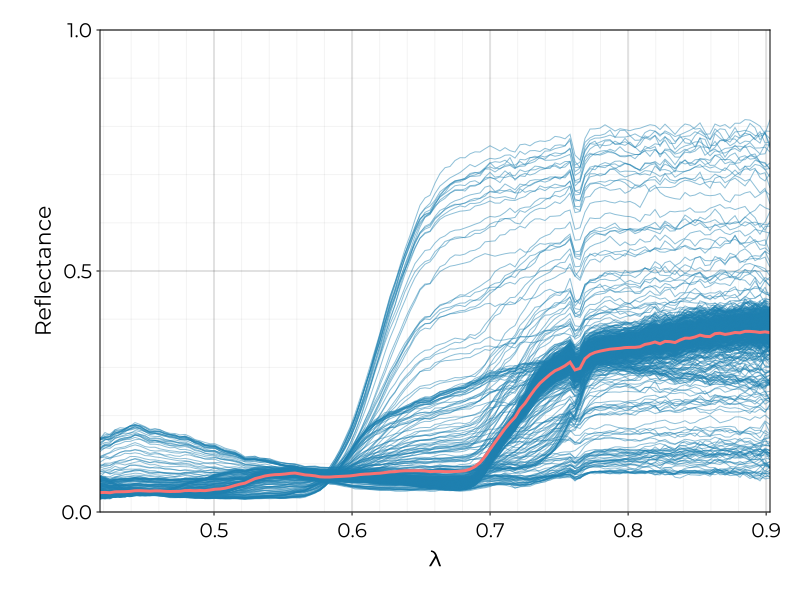

In [15]:
fig = Figure();
ax = Axis(fig[1,1], xlabel="λ", ylabel="Reflectance")
let
    for i ∈ axes(X_all, 1)
        lines!(ax, λs, X_all[i,:], color=(mints_colors[3], 0.5), linewidth=1)
    end

    lines!(ax, λs, mean(X_all, dims=1)[:], color=mints_colors[2], linewidth=3)
end
xlims!(ax, λs[1], λs[end])
ylims!(ax, 0, 1)

save(joinpath(figpath, "all", "spectra-all.png"), fig)
save(joinpath(figpath, "all", "spectra-all.pdf"), fig)

fig

Large targets dataset

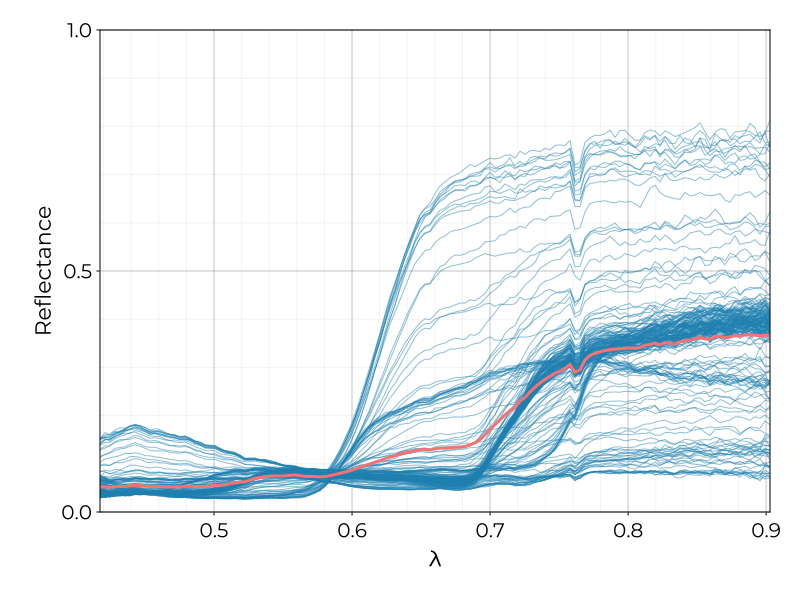

In [16]:
fig = Figure();
ax = Axis(fig[1,1], xlabel="λ", ylabel="Reflectance")
let
    for i ∈ axes(X_large, 1)
        lines!(ax, λs, X_large[i,:], color=(mints_colors[3], 0.5), linewidth=1)
    end

    lines!(ax, λs, mean(X_large, dims=1)[:], color=mints_colors[2], linewidth=3)
end
xlims!(ax, λs[1], λs[end])
ylims!(ax, 0, 1)

save(joinpath(figpath, "large", "spectra-all.png"), fig)
save(joinpath(figpath, "large", "spectra-all.pdf"), fig)

fig

Small targets dataset

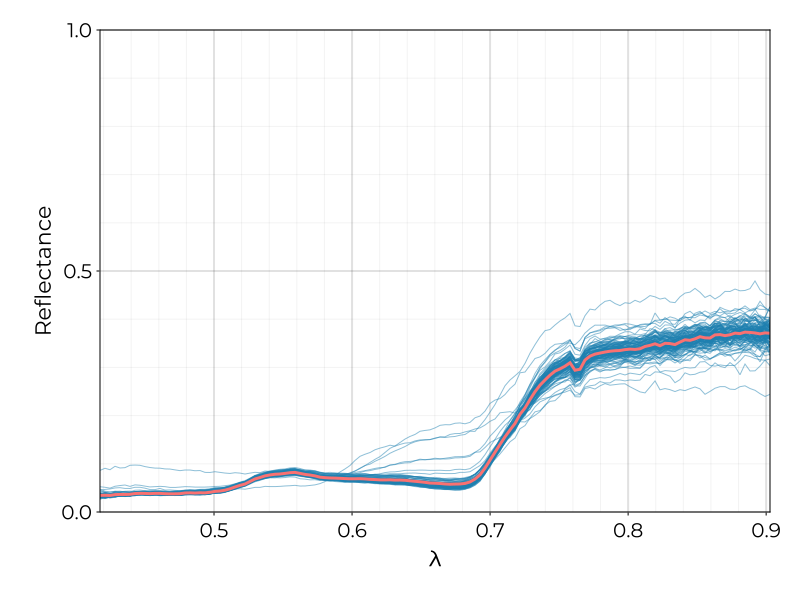

In [17]:
fig = Figure();
ax = Axis(fig[1,1], xlabel="λ", ylabel="Reflectance")
let
    for i ∈ axes(X_small, 1)
        lines!(ax, λs, X_small[i,:], color=(mints_colors[3], 0.5), linewidth=1)
    end

    lines!(ax, λs, mean(X_small, dims=1)[:], color=mints_colors[2], linewidth=3)
end
xlims!(ax, λs[1], λs[end])
ylims!(ax, 0, 1)

save(joinpath(figpath, "small", "spectra-all.png"), fig)
save(joinpath(figpath, "small", "spectra-all.pdf"), fig)

fig

# Examine Intrinsic Dimensionality of Dataset

In [19]:
Svd = svd(X_all' .- mean(X_all, dims=1)[:])
Svd.S
pca_vars_all = (abs2.(Svd.S) ./ (nrow(df_all)-1));

size(X_large)
Svd = svd(X_large' .- mean(X_large, dims=1)[:])
Svd.S
pca_vars_large= (abs2.(Svd.S) ./ (nrow(df_large)-1));

size(X_small)
Svd = svd(X_small' .- mean(X_small, dims=1)[:])
Svd.S
pca_vars_small= (abs2.(Svd.S) ./ (nrow(df_small)-1));

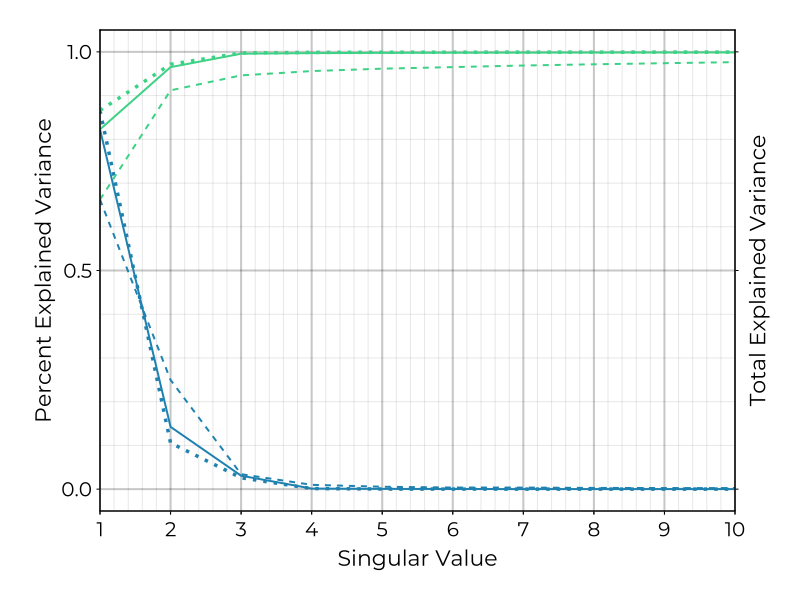

In [20]:
fig = Figure();
ax = Axis(fig[1,1], xlabel="Singular Value", ylabel="Percent Explained Variance");
ax2 = fig[1,1] = Axis(fig, ylabel = "Total Explained Variance");
linkxaxes!(ax, ax2)
linkyaxes!(ax, ax2)

ax2.yaxisposition = :right
ax2.yticklabelalign = (:left, :center)
ax2.xticklabelsvisible = false
ax2.xticklabelsvisible = false
ax2.xlabelvisible = false
ax2.yticklabelsvisible = false

lines!(ax, 1:length(pca_vars_all), pca_vars_all./sum(pca_vars_all), linewidth=2, color=mints_colors[3], linestyle=:solid)
lines!(ax, 1:length(pca_vars_large), pca_vars_large./sum(pca_vars_large), linewidth=3.5, color=mints_colors[3], linestyle=:dot)
lines!(ax, 1:length(pca_vars_small), pca_vars_small./sum(pca_vars_small), linewidth=2, color=mints_colors[3], linestyle=:dash)

lines!(ax2, 1:length(pca_vars_all), cumsum(pca_vars_all)./sum(pca_vars_all), linewidth=2, color=mints_colors[1], linestyle=:solid)
lines!(ax2, 1:length(pca_vars_large), cumsum(pca_vars_large)./sum(pca_vars_large), linewidth=3.5, color=mints_colors[1], linestyle=:dot)
lines!(ax2, 1:length(pca_vars_small), cumsum(pca_vars_small)./sum(pca_vars_small), linewidth=2, color=mints_colors[1], linestyle=:dash)

xlims!(ax2, 1, 10)

save(joinpath(figpath, "pca-explained-variance.png"), fig)
save(joinpath(figpath, "pca-explained-variance.pdf"), fig)

fig

# Test 1: Linear Mixing on *All* Dataset

In [21]:
function spectral_angle(r1, r2)
    return acos(dot(r1, r2)/(norm(r1) * norm(r2)))
end

spectral_angle (generic function with 1 method)

In [22]:
savepath = joinpath(figpath, "all")
@assert ispath(savepath)

In [23]:
n_nodes = 50_000
λ = 10
Nv = 7

7

In [24]:
gsm = GSMBig(
    n_nodes=n_nodes,
    Nv=Nv, 
    λ=λ, 
    nonlinear=false,
    linear=true, 
    make_positive=true,
    tol=1e-6, 
    nepochs=500,
    rand_init=false, 
    rng=StableRNG(42)
)

mach = machine(gsm, df_all)
fit!(mach, verbosity=1)

[ Info: Training machine(GSMBig(n_nodes = 50000, …), …).


iter: 1, Q=202164.28548699984, log-likelihood = 217555.49963241577
iter: 2, Q=252488.95509945328, log-likelihood = 268349.3559118535
iter: 3, Q=288976.88519494043, log-likelihood = 303748.250427103
iter: 4, Q=319476.041124045, log-likelihood = 332527.73520583985
iter: 5, Q=358186.9138629716, log-likelihood = 368253.707100083
iter: 6, Q=382054.27415100153, log-likelihood = 390799.23572885536
iter: 7, Q=404437.755943596, log-likelihood = 412767.34745983017
iter: 8, Q=427841.7152162317, log-likelihood = 435987.91493576387
iter: 9, Q=448463.3158604143, log-likelihood = 456539.2237088677
iter: 10, Q=465061.24343629344, log-likelihood = 473014.8286571738
iter: 11, Q=476060.94346834265, log-likelihood = 483975.67045367666
iter: 12, Q=480631.9340959102, log-likelihood = 488437.5199690396
iter: 13, Q=482929.05611620814, log-likelihood = 490754.29194768565
iter: 14, Q=485521.07466218725, log-likelihood = 493404.90125512483
iter: 15, Q=488382.4249112216, log-likelihood = 496343.4751156191
iter: 1

┌ Error: Problem fitting the machine machine(GSMBig(n_nodes = 50000, …), …). 
└ @ MLJBase ~/.julia/packages/MLJBase/QyZZM/src/machines.jl:694
[ Info: Running type checks... 
[ Info: Type checks okay. 


LoadError: InterruptException: